In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt


def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

In [2]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

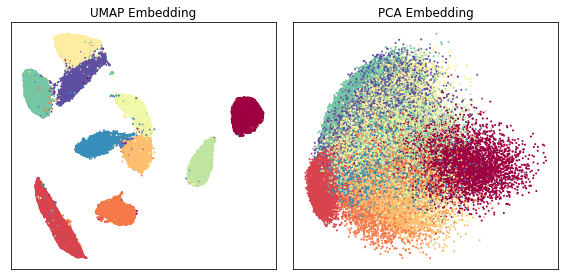

In [3]:
import os
import pickle
from umap import UMAP
from sklearn.decomposition import PCA


def create_embeddings(data, ignore_cache=False):
    umap_dir = "cache/umap.pickle"
    pca_dir = "cache/pca.pickle"

    if not os.path.isfile(umap_dir) or ignore_cache:
        umap_reducer = UMAP(random_state=42).fit(data)
        pickle.dump(umap_reducer, open(umap_dir, "wb"))
    else:
        umap_reducer = pickle.load(open(umap_dir, "rb"))

    if not os.path.isfile(pca_dir) or ignore_cache:
        pca_reducer = PCA(n_components=2, random_state=42).fit(data)
        pickle.dump(pca_reducer, open(pca_dir, "wb"))
    else:
        pca_reducer = pickle.load(open(pca_dir, "rb"))
        
    return umap_reducer, pca_reducer


umap_reducer, pca_reducer = create_embeddings(train_x.reshape(-1, 784), ignore_cache=False)
umap_data = umap_reducer.transform(train_x.reshape(-1, 784))
pca_data = pca_reducer.transform(train_x.reshape(-1, 784))


def plot_embeddings():
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
    axes[0].scatter(umap_data[:,0], umap_data[:,1], s=1, c=train_labels, cmap='Spectral')
    axes[0].set_title("UMAP Embedding")

    axes[1].scatter(pca_data[:,0], pca_data[:,1], s=1, c=train_labels, cmap='Spectral')
    axes[1].set_title("PCA Embedding")
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()
    
plot_embeddings()

Using TensorFlow backend.
W0213 16:29:52.271373 140437177079616 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.3312 - categorical_accuracy: 0.3816 - val_loss: 0.2518 - val_categorical_accuracy: 0.7138
Epoch 2/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.2195 - categorical_accuracy: 0.7554 - val_loss: 0.1888 - val_categorical_accuracy: 0.8142
Epoch 3/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1691 - categorical_accuracy: 0.8241 - val_loss: 0.1482 - val_categorical_accuracy: 0.8498
Epoch 4/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1359 - categorical_accuracy: 0.8594 - val_loss: 0.1215 - val_categorical_accuracy: 0.8741
Epoch 5/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1137 - categorical_accuracy: 0.8770 - val_loss: 0.1043 - val_categorical_accuracy: 0.8874
Epoch 6/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.0988 - categor

60000/60000 [==============================] - 3s 46us/step - loss: 0.0368 - categorical_accuracy: 0.9494 - val_loss: 0.0460 - val_categorical_accuracy: 0.9324
Epoch 49/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0368 - categorical_accuracy: 0.9488 - val_loss: 0.0458 - val_categorical_accuracy: 0.9342
Epoch 50/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.0365 - categorical_accuracy: 0.9492 - val_loss: 0.0470 - val_categorical_accuracy: 0.9310


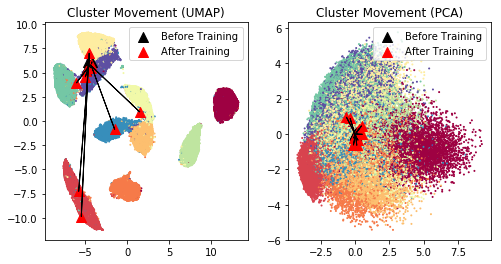

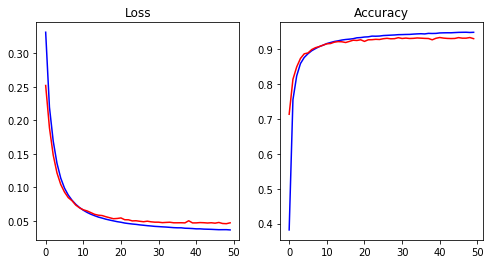

In [4]:
import keras
import keras.layers as layers
import keras.models as models
from model import GaussMembership, normalized_product_fn


def plot_cluster_movement(ax, data, init, current):
    change = current - init
    
    ax.scatter(data[:,0], data[:,1], s=1, c=train_labels, cmap='Spectral')
    s1 = ax.scatter(init[:,0], init[:,1], s=100, c="k", marker="^")
    s2 = ax.scatter(current[:,0], current[:,1], s=100, c="r", marker="^")
    
    for i in range(change.shape[0]):
        ax.arrow(init[i,0], init[i,1], change[i,0], change[i,1])
    ax.legend([s1, s2], ["Before Training", "After Training"])


# create the model
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    GaussMembership(10),
    layers.Lambda(lambda x: normalized_product_fn(x)),
    layers.Dense(10, activation="sigmoid"),])

# set weights randomly
model.layers[1].set_weights((
    # multiplying the by the mean is a way to ensure that the centers occupy the same subset of the
    # feature space as the input data
    np.random.normal(1., 0.1, size=(10,784)) * np.mean(train_x.reshape(-1, 784), axis=0, keepdims=True),
    np.random.normal(1., 0.1, size=(10,784))))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

init_mu, init_sigma = model.layers[1].get_weights()

# train the model
history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=50,
    validation_data=(test_x, test_y),
    verbose=1,
    shuffle=True)

final_mu, final_sigma = model.layers[1].get_weights()

# plot the cluster movement
fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Cluster Movement (UMAP)")
plot_cluster_movement(
    axes[0], umap_data,
    umap_reducer.transform(init_mu), 
    umap_reducer.transform(final_mu))

axes[1].set_title("Cluster Movement (PCA)")
plot_cluster_movement(
    axes[1], pca_data,
    pca_reducer.transform(init_mu), 
    pca_reducer.transform(final_mu))

# plot the loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Accuracy")
#axes[1].set_ylim((0.8, 1))
axes[1].plot(history.history["categorical_accuracy"], c="b")
axes[1].plot(history.history["val_categorical_accuracy"], c="r")

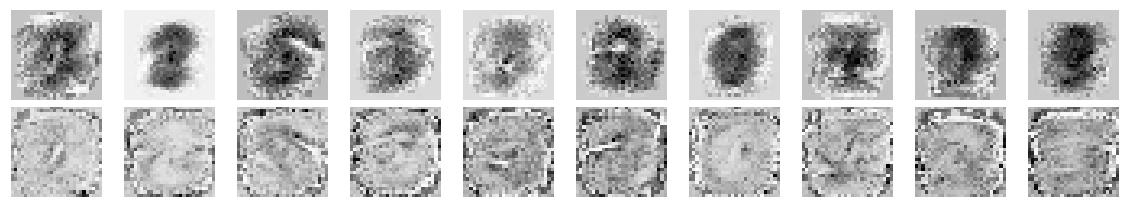

In [5]:
fig, axes = plt.subplots(2, 10, figsize=(16,3))
for i in range(10):
    axes[0][i].imshow(final_mu[i,:].reshape(28, 28), cmap="Greys", interpolation="none")
    axes[1][i].imshow(final_sigma[i,:].reshape(28, 28), cmap="Greys", interpolation="none")

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.4204 - categorical_accuracy: 0.1495 - val_loss: 0.3154 - val_categorical_accuracy: 0.2698
Epoch 2/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2751 - categorical_accuracy: 0.4856 - val_loss: 0.2258 - val_categorical_accuracy: 0.6645
Epoch 3/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1943 - categorical_accuracy: 0.7379 - val_loss: 0.1684 - val_categorical_accuracy: 0.7770
Epoch 4/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1552 - categorical_accuracy: 0.7784 - val_loss: 0.1414 - val_categorical_accuracy: 0.7920
Epoch 5/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1340 - categorical_accuracy: 0.7997 - val_loss: 0.1253 - val_categorical_accuracy: 0.8107
Epoch 6/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1206 - categor

60000/60000 [==============================] - 3s 47us/step - loss: 0.0377 - categorical_accuracy: 0.9493 - val_loss: 0.0497 - val_categorical_accuracy: 0.9297
Epoch 49/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0376 - categorical_accuracy: 0.9486 - val_loss: 0.0508 - val_categorical_accuracy: 0.9302
Epoch 50/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0372 - categorical_accuracy: 0.9498 - val_loss: 0.0498 - val_categorical_accuracy: 0.9286


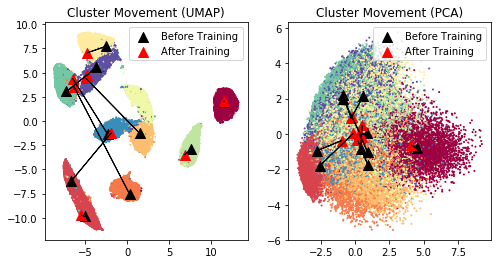

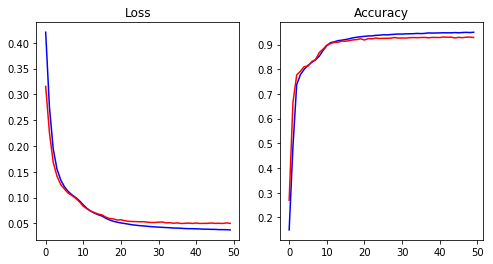

In [6]:
import skfuzzy as skf


# create the model
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    GaussMembership(10),
    layers.Lambda(lambda x: normalized_product_fn(x)),
    layers.Dense(10, activation="sigmoid"),])

init_mu, memberships, u0, d, jm, p, fpc = skf.cmeans(
    train_x.reshape(-1, 784).T, 10, 1.1, 1e-8, 1000, seed=0)

# set weights with fcm
model.layers[1].set_weights((
    init_mu,
    np.random.normal(1., 0.1, size=(10,784))))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

init_mu, init_sigma = model.layers[1].get_weights()

# train the model
history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=50,
    validation_data=(test_x, test_y),
    verbose=1,
    shuffle=True)

final_mu, final_sigma = model.layers[1].get_weights()

# plot the cluster movement
fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Cluster Movement (UMAP)")
plot_cluster_movement(
    axes[0], umap_data,
    umap_reducer.transform(init_mu), 
    umap_reducer.transform(final_mu))

axes[1].set_title("Cluster Movement (PCA)")
plot_cluster_movement(
    axes[1], pca_data,
    pca_reducer.transform(init_mu), 
    pca_reducer.transform(final_mu))

# plot the loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Accuracy")
#axes[1].set_ylim((0.8, 1))
axes[1].plot(history.history["categorical_accuracy"], c="b")
axes[1].plot(history.history["val_categorical_accuracy"], c="r")

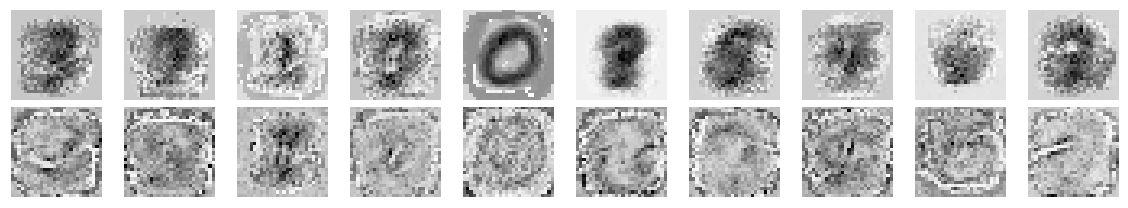

In [7]:
fig, axes = plt.subplots(2, 10, figsize=(16,3))
for i in range(10):
    axes[0][i].imshow(final_mu[i,:].reshape(28, 28), cmap="Greys", interpolation="none")
    axes[1][i].imshow(final_sigma[i,:].reshape(28, 28), cmap="Greys", interpolation="none")

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)